In [ ]:
# !git clone https://github.com/fizyr/keras-retinanet.git
# %cd keras-retinanet/
# !pip install .
# !python setup.py build_ext --inplace
# %cd ..
# !wget -nc https://lazyprogrammer.me/course_files/face_detection.json

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import requests
import urllib
import os
import json

from PIL import Image
from glob import glob

from keras_retinanet import models
from keras_retinanet.utils.image import preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

plt.rcParams['figure.figsize'] = [20, 10]

In [3]:
# read the training data
j = json.loads(open('face_detection.json').readline())
j

{'annotation': [{'imageHeight': 333,
   'imageWidth': 650,
   'label': ['Face'],
   'notes': '',
   'points': [{'x': 0.08615384615384615, 'y': 0.3063063063063063},
    {'x': 0.1723076923076923, 'y': 0.45345345345345345}]},
  {'imageHeight': 333,
   'imageWidth': 650,
   'label': ['Face'],
   'notes': '',
   'points': [{'x': 0.583076923076923, 'y': 0.2912912912912913},
    {'x': 0.6584615384615384, 'y': 0.46846846846846846}]}],
 'content': 'http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb064277d86016431e33e4e003d/8186c3d1-e9d4-4550-8ec1-a062a7628787___0-26.jpg.jpeg',
 'extras': None}

In [4]:
df = pd.read_json('face_detection.json', lines=True)
df.head(3)

content  ... extras
0  http://com.dataturks.a96-i23.open.s3.amazonaws...  ...    NaN
1  http://com.dataturks.a96-i23.open.s3.amazonaws...  ...    NaN
2  http://com.dataturks.a96-i23.open.s3.amazonaws...  ...    NaN

[3 rows x 3 columns]

In [5]:
df.shape

(409, 3)

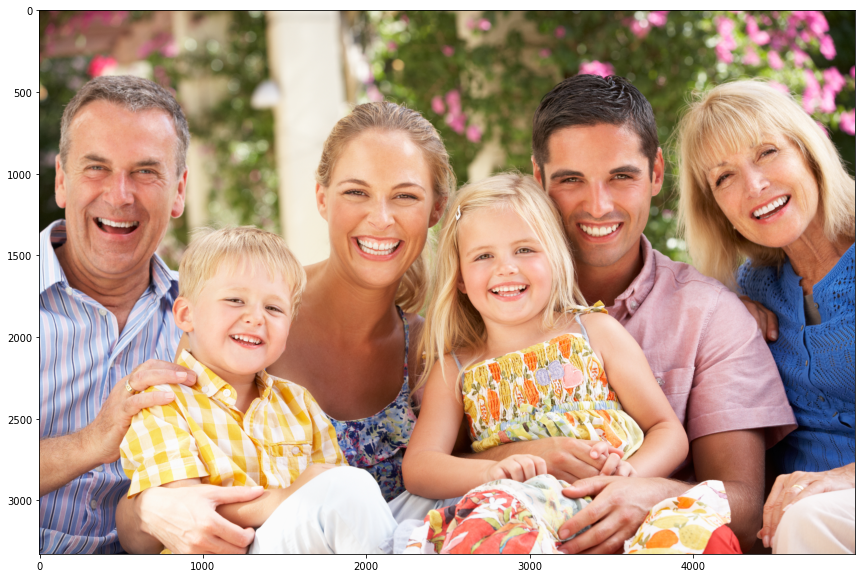

In [6]:
# checking random sample image

# download image 
url = df['content'].sample(1,random_state=42).values[0]
r = requests.get(url)

# save image
with open('testimg.jpg', 'wb') as f:
  f.write(r.content)

# display image
im = Image.open('testimg.jpg')
plt.imshow(im)

In [7]:
# preparaing data for training format required by RetinaNet
converted_data_train = {'image_name': [],
                        'x_min': [], 'y_min': [], 
                        'x_max': [], 'y_max': [],
                        'class_name': [],}

converted_data_test = {'image_name': [],
                       'x_min': [],'y_min': [],
                       'x_max': [],'y_max': [],
                       'class_name': [],}

if not os.path.exists('faces'):
  os.mkdir('faces')

In [8]:
idx = 0 # global counter for filenames

def map_to_data(row, converted_data):
  global idx
  r = requests.get(row['content'])
  filepath = f'faces/face_{idx}.jpg'

  # don't bother to overwrite
  if not os.path.exists(filepath):
    with open(filepath, 'wb') as f:
      f.write(r.content)

  # there could be more than 1 face per image
  for anno in row['annotation']:
    converted_data['image_name'].append(filepath)

    width = anno['imageWidth']
    height = anno['imageHeight']

    # calculate box coordinates
    x1 = int(round(anno['points'][0]['x'] * width))
    y1 = int(round(anno['points'][0]['y'] * height))
    x2 = int(round(anno['points'][1]['x'] * width))
    y2 = int(round(anno['points'][1]['y'] * height))

    converted_data['x_min'].append(x1)
    converted_data['y_min'].append(y1)
    converted_data['x_max'].append(x2)
    converted_data['y_max'].append(y2)

    # they are all the same class
    converted_data['class_name'].append('face')
  
  # update counter
  idx += 1

In [9]:
# we must split BEFORE converting the data
# after converting the data, multiple rows will have the same image
# we won't want to split then
train_df, test_df = train_test_split(df, test_size=0.2)

In [10]:
# this will be slow since it has to download all the images

# just in case we run again later
idx = 0

# train
train_df.apply(lambda row: map_to_data(row, converted_data_train), axis=1)

# test
test_df.apply(lambda row: map_to_data(row, converted_data_test), axis=1)

76     None
297    None
314    None
262    None
179    None
       ... 
381    None
62     None
309    None
283    None
69     None
Length: 82, dtype: object

In [11]:
# this will overwrite the previous dfs
train_df = pd.DataFrame(converted_data_train)
test_df = pd.DataFrame(converted_data_test)
train_df.head()

image_name  x_min  y_min  x_max  y_max class_name
0  faces/face_0.jpg    134     46    273    226       face
1  faces/face_1.jpg     37     19    166    162       face
2  faces/face_1.jpg    191    102    286    222       face
3  faces/face_1.jpg    259     73    351    177       face
4  faces/face_1.jpg    372    107    439    208       face

In [12]:
train_df.shape

(925, 6)

In [13]:
train_df[train_df['image_name'] == 'faces/face_1.jpg']

image_name  x_min  y_min  x_max  y_max class_name
1   faces/face_1.jpg     37     19    166    162       face
2   faces/face_1.jpg    191    102    286    222       face
3   faces/face_1.jpg    259     73    351    177       face
4   faces/face_1.jpg    372    107    439    208       face
5   faces/face_1.jpg    522      8    647    151       face
6   faces/face_1.jpg    698    134    826    263       face
7   faces/face_1.jpg    616     97    686    194       face
8   faces/face_1.jpg    873     46    944    155       face
9   faces/face_1.jpg    805     96    892    201       face
10  faces/face_1.jpg    197    257    316    412       face
11  faces/face_1.jpg    418    280    528    418       face
12  faces/face_1.jpg    574    330    702    471       face

In [14]:
def show_image_with_boxes(df):
  # pick a random image
  filepath = df.sample()['image_name'].values[0]

  # get all rows for this image
  df2 = df[df['image_name'] == filepath]
  im = np.array(Image.open(filepath))

  # if there's a PNG it will have alpha channel
  im = im[:,:,:3]

  for idx, row in df2.iterrows():
    box = [row['x_min'],row['y_min'],
           row['x_max'],row['y_max'], ]
    print(box)
    draw_box(im, box, color=(255, 0, 0))

  plt.axis('off')
  plt.imshow(im)
  plt.show()

[106, 624, 354, 883]
[508, 286, 756, 553]
[1016, 82, 1256, 386]
[1256, 193, 1433, 407]
[1603, 11, 1883, 373]
[1888, 63, 2153, 410]


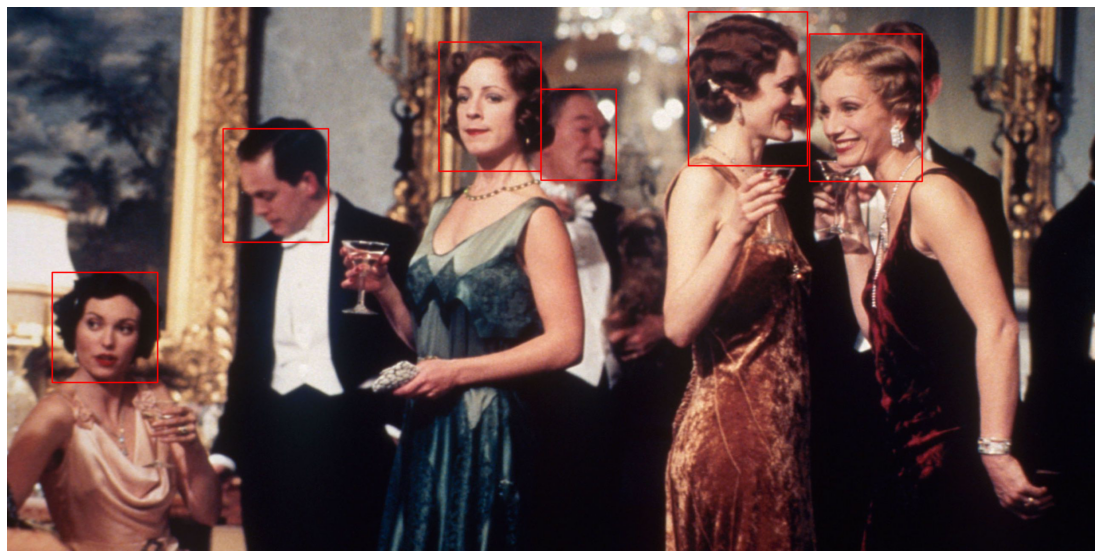

In [15]:
show_image_with_boxes(train_df)

In [16]:
# save training data
train_df.to_csv('annotations.csv', index=False, header=None)

In [17]:
# save output target names
classes = ['face']
with open('classes.csv', 'w') as f:
  for i, class_name in enumerate(classes):
    f.write(f'{class_name},{i}\n')

In [18]:
if not os.path.exists('snapshots'):
  os.mkdir('snapshots')

In [19]:
PRETRAINED_MODEL = 'snapshots/_pretrained_model.h5'

URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'

urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)

print('Downloaded pretrained model to ' + PRETRAINED_MODEL)

Downloaded pretrained model to snapshots/_pretrained_model.h5


In [20]:
!ls keras-retinanet

build		 images		  README.md	    setup.py
CONTRIBUTORS.md  keras_retinanet  requirements.txt  snapshots
examples	 LICENSE	  setup.cfg	    tests


In [21]:
!keras-retinanet/keras_retinanet/bin/train.py    --freeze-backbone \
                                                --random-transform \
                                                --weights {PRETRAINED_MODEL} \
                                                --batch-size 8 \
                                                --steps 500 \
                                                --epochs 15 \
                                                csv annotations.csv classes.csv

2020-12-13 18:41:16.334587: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Creating model, this may take a second...
2020-12-13 18:41:17.761081: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-12-13 18:41:17.811465: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-12-13 18:41:17.812087: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.73GiB deviceMemoryBandwidth: 298.08GiB/s
2020-12-13 18:41:17.812139: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-12-13 18:41:17.996731: I t

In [22]:
!ls snapshots

_pretrained_model.h5  resnet50_csv_01.h5


In [23]:
model_paths = glob('snapshots/resnet50_csv_*.h5')
latest_path = sorted(model_paths)[-1]
print("path:", latest_path)

model = models.load_model(latest_path, backbone_name='resnet50')
model = models.convert_model(model)

label_map = {}
for line in open('classes.csv'):
  row = line.rstrip().split(',')
  label_map[int(row[1])] = row[0]

path: snapshots/resnet50_csv_01.h5


In [24]:
def show_image_with_predictions(df, threshold=0.6):
  # choose a random image
  row = df.sample()
  filepath = row['image_name'].values[0]
  print("filepath:", filepath)

  # get all rows for this image
  df2 = df[df['image_name'] == filepath]
  im = np.array(Image.open(filepath))
  print("im.shape:", im.shape)

  # if there's a PNG it will have alpha channel
  im = im[:,:,:3]

  # plot true boxes
  for idx, row in df2.iterrows():
    box = [row['x_min'],row['y_min'],
           row['x_max'],row['y_max'],]
    print(box)
    draw_box(im, box, color=(255, 0, 0))
  
  ### plot predictions ###

  # get predictions
  imp = preprocess_image(im)
  imp, scale = resize_image(im)

  boxes, scores, labels = model.predict_on_batch(
    np.expand_dims(imp, axis=0) )

  # standardize box coordinates
  boxes /= scale

  # loop through each prediction for the input image
  for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # scores are sorted so we can quit as soon
    # as we see a score below threshold
    if score < threshold:
      break

    box = box.astype(np.int32)
    color = label_color(label)
    draw_box(im, box, color=color)

    class_name = label_map[label]
    caption = f"{class_name} {score:.3f}"
    draw_caption(im, box, caption)

  plt.axis('off')
  plt.imshow(im)
  plt.show()


filepath: faces/face_167.jpg
im.shape: (473, 710, 3)
[275, 126, 344, 234]
[368, 5, 451, 105]
[217, 113, 250, 149]


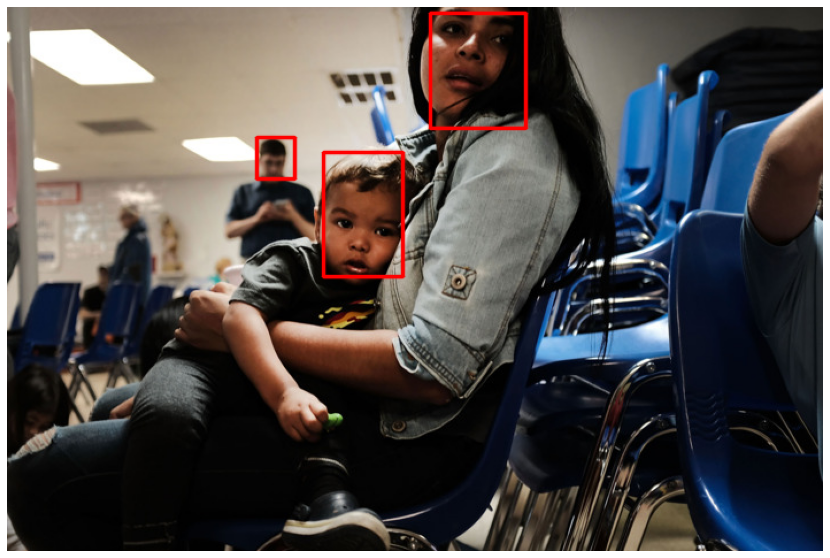

In [25]:
show_image_with_predictions(train_df, threshold=0.3)

filepath: faces/face_368.jpg
im.shape: (225, 800, 3)
[70, 50, 128, 127]
[118, 138, 184, 194]
[179, 82, 242, 155]
[325, 89, 366, 137]
[373, 58, 415, 110]
[356, 153, 403, 194]
[472, 110, 507, 148]
[472, 17, 509, 57]
[614, 9, 659, 74]
[676, 150, 729, 209]
[692, 2, 755, 59]


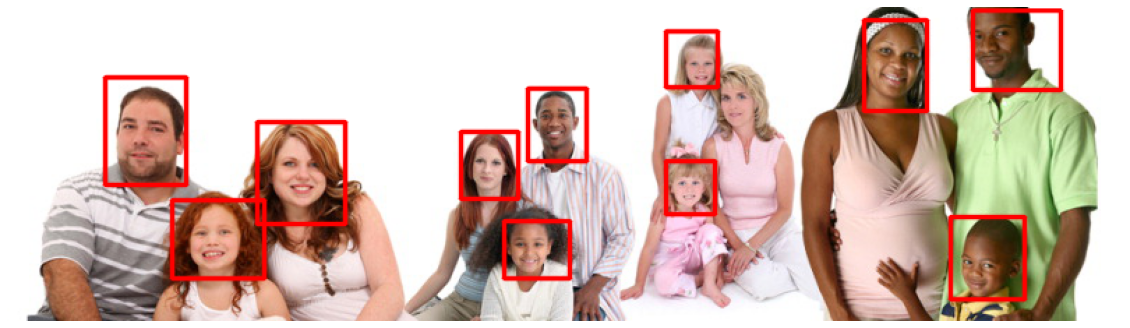

In [26]:
show_image_with_predictions(test_df, threshold=0.4)

filepath: faces/face_401.jpg
im.shape: (2118, 3783, 3)
[1736, 946, 2272, 1538]
[2275, 595, 2870, 1150]
[1668, 225, 2177, 721]
[691, 151, 1193, 786]


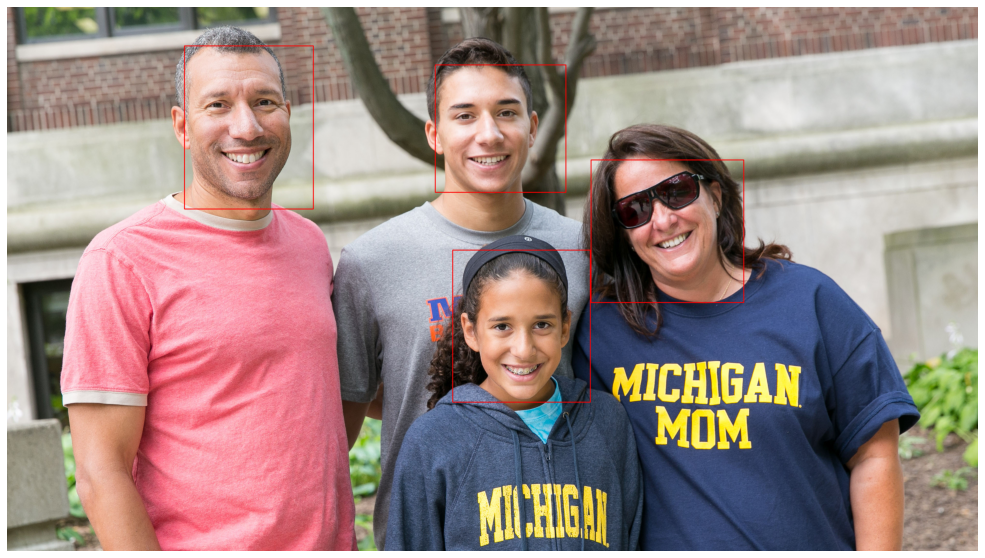

In [27]:
show_image_with_predictions(test_df, threshold=0.4)